# AnoGANの作成
異常検知において異常画像は集めにくいので、正常画像のみでディープラーニングの学習を実施し、異常画像を検出できるアルゴリズムを構築するのがAnoGAN

## 目標

1.	AnoGANでテスト画像に最も似た画像を生成するノイズzを求める方法を理解する
2.	AnoGANを実装し、手書き数字画像で異常検知が生成できる

1. 正常画像のみでDLの学習を実施しする
2. テストしたい画像（生成画像ではない）を用意し、テストしたい画像と最もよく似た画像をGで生成できる生成ノイズzを求める。これも損失関数を用意して学習で求める
3. 求めた生成ノイズｚから画像を生成し、テスト画像との違いを求める。生成器は正常画像しか生成できないので、異常画像を生成しようとすると違いが大きくなる

## Library

In [6]:
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [ ]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [69]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)

使用デバイス： cpu


## Generator, Discriminatorの作成

In [16]:
class Generator(nn.Module):
    
    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size*8, kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size*8),
            nn.ReLU(inplace=True))
        
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size*8, image_size*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size*4),
            nn.ReLU(inplace=True))
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size*4, image_size*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size*2),
            nn.ReLU(inplace=True))
            
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size*2, image_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))
        
        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh())
    
    # 生成乱数をzとしている
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        
        return out
    

# Generatorの損失を逆伝播するときにDiscriminatorを通るので、
# 誤差が伝わりやすいようにLeakyReLUを使う
class Discriminator(nn.Module):
    def __init__(self, z_dim, image_size=64):
        super(Discriminator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        # 一つのモジュールだけなのでnn.Sequentialいらない
        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        feature = out  # 最後にチャネルを１つに集約する手前の情報
        feature = feature.view(feature.size()[0], -1)  # (batch_size, -)
        
        out = self.last(out)
        
        return out, feature

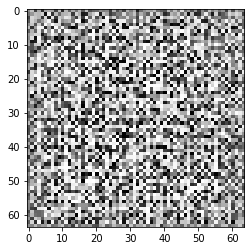

torch.Size([5, 1, 1, 1])


tensor([[[[0.5011]]],


        [[[0.5003]]],


        [[[0.4989]]],


        [[[0.5015]]],


        [[[0.5002]]]], grad_fn=<SigmoidBackward>)

In [30]:
# 動作確認
import matplotlib.pyplot as plt
%matplotlib inline

z = torch.randn(5, 20)
z = z.view(z.size(0), z.size(1), 1, 1)
G = Generator(z_dim=20, image_size=64)
D = Discriminator(z_dim=20, image_size=64)

fake_images = G(z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

d_out, d_feature = D(fake_images)
print(d_out.size())
# 出力にsigmoidかけて0-1に変換
nn.Sigmoid()(d_out)

## DataLoaderの作成

In [31]:
def make_datapath_list():
    """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """

    train_img_list = list()  # 画像ファイルパスを格納

    for img_idx in range(200):
        img_path = "./data/img_78/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/img_78/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list

In [32]:
class ImageTransform():
    """画像の前処理クラス"""

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)

In [33]:
class GAN_Img_Dataset(data.Dataset):
    """画像のDatasetクラス。PyTorchのDatasetクラスを継承"""

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''前処理をした画像のTensor形式のデータを取得'''

        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅]白黒

        # 画像の前処理
        img_transformed = self.transform(img)

        return img_transformed


In [42]:
# DataLoaderの作成と動作確認

# ファイルリストを作成
train_img_list=make_datapath_list()

# Datasetを作成
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list, transform=ImageTransform(mean, std))

# DataLoaderを作成
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

# 動作確認
batch_iter = iter(train_dataloader)
for i in range(3):
    images = next(batch_iter)
    print(images.size())

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])


## 学習させる

In [39]:
# ネットワークの初期化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
# 初期化の実施
G.apply(weights_init)
D.apply(weights_init)

print("ネットワークの初期化完了")

ネットワークの初期化完了


In [40]:
# モデル学習させる関数
# 今まで作ってきたものと一緒
# 今回は正常画像だけでこのモデルを訓練する

def train_model(G, D, dataloader, num_epochs):
    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # 最適化手法の設定
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    # 誤差関数を定義
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # パラメータをハードコーディング
    z_dim = 20
    mini_batch_size = 64

    # ネットワークをGPUへ
    G.to(device)
    D.to(device)

    G.train()  # モデルを訓練モードに
    D.train()  # モデルを訓練モードに

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # イテレーションカウンタをセット
    iteration = 1
    logs = []

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epochの損失和
        epoch_d_loss = 0.0  # epochの損失和

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('（train）')

        # データローダーからminibatchずつ取り出すループ
        for imges in dataloader:

            # --------------------
            # 1. Discriminatorの学習
            # --------------------
            # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
            if imges.size()[0] == 1:
                continue

            # GPUが使えるならGPUにデータを送る
            imges = imges.to(device)

            # 正解ラベルと偽ラベルを作成
            # epochの最後のイテレーションはミニバッチの数が少なくなる
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            # 真の画像を判定
            d_out_real, _ = D(imges)

            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images)

            # 誤差を計算
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generatorの学習
            # --------------------
            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images)

            # 誤差を計算
            g_loss = criterion(d_out_fake.view(-1), label_real)

            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. 記録
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    
    print("総イテレーション回数:", iteration)

    return G, D


In [ ]:
# 学習検証の実施
num_epochs = 300
G, D = train_model(G, D, dataloader=train_dataloader, num_epochs=num_epochs)

## AnoGANの本体
正常画像のみで訓練したGを使って、テスト画像と最も近い画像を生成する乱数zを求めるためのDeep Learningモデル<br>
AnoGANの損失関数は２種類ある<br>


residual loss : テスト画像ｘと生成画像fake_imgのピクセルレベルの差の絶対値<br>
residual loss だけでは最適なzを取得するための学習が進みづらいので、識別機Dを使って特徴量を抽出し、ピクセルレベルの差を計算する。これをdiscrimination lossという


loss = (1-λ)× residual loss + λ× discrimination loss

In [41]:
def Anomaly_score(x, fake_img, D, Lambda=0.1):
    # テスト画像ｘと生成画像fake_imgのピクセルレベルの差の絶対値を求める
    # ミニバッチごとに和を求める
    residual_loss = torch.abs(x-fake_img)
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)
    residual_loss = torch.sum(residual_loss, dim=1)
    
    # テスト画像ｘと生成画像fake_imgを識別機Dに入力し特徴量を取りだす
    _, x_feature = D(x)
    _, G_feature = D(fake_img)
    
    # テスト画像ｘの特徴量と生成画像fake_imgの特徴量の差の絶対値を求める
    # ミニバッチ毎に和を求める
    discrimination_loss = torch.abs(x_feature-G_feature)
    discrimination_loss = discrimination_loss.view(discrimination_loss.size()[0], -1)
    
    # ミニバッチ毎に２種類の損失の足し算をする
    loss_each = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    
    # ミニバッチ全部の損失を求める
    total_loss = torch.sum(loss_each)
    
    return total_loss, loss_each, residual_loss  # なんで３種類必要なのか

## テスト画像で異常検知


In [45]:
# テスト用のDataLoaderを作成

def make_test_datapath_list():
    """
    テスト画像（２）データへのファイルパスリストを作成
    """
    test_img_list = []
    
    # ,7 8, 2の画像をそれぞれ５枚ずつ
    for img_idx in range(5):
        img_path = './data/test/img_7_' + str(img_idx) + '.jpg'
        test_img_list.append(img_path)
        
        img_path = './data/test/img_8_' + str(img_idx) + '.jpg'
        test_img_list.append(img_path)
        
        img_path = './data/test/img_2_' + str(img_idx) + '.jpg'
        test_img_list.append(img_path)
        
    return test_img_list

# ファイルリスト作成
test_img_list = make_test_datapath_list()

# Dataset作成
mean = (0.5, )
std = (0.5, )
test_dataset = GAN_Img_Dataset(
    file_list=test_img_list, transform=ImageTransform(mean, std))

# DataLoader作成
batch_size = 5
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)


In [62]:
# 動作確認
batch_iter = iter(test_dataloader)

torch.Size([5, 1, 64, 64])


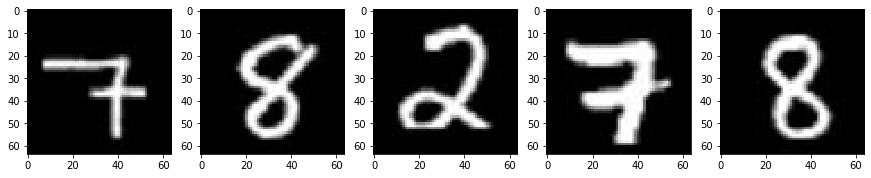

In [63]:
# 3回まで実行できる　（上で１５枚集めたから）
# 4回目実行するとエラーStopIterationになる
images = next(batch_iter)

print(images.size())

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i][0].cpu().detach().numpy(), 'gray')  # [0]はチャネル

In [70]:
# 異常検知したい画像
print(images.size())
x = images[0:5]  # なぜわざわざこれやるの？
print(x.size())
x = x.to(device)  # 変数は代入しないといけない

# 異常検知したい画像を生成するための初期乱数
z = torch.randn(5, 20).to(device)
z = z.view(z.size(0), z.size(1), 1, 1)

# 変数zを微分を求めることができるようにrequires_gradをTrueに
z.requires_grad = True

# 変数zを更新できるようにzの最適化関数を設定
z_optimizer = torch.optim.Adam([z], lr=1e-3)

torch.Size([5, 1, 64, 64])
torch.Size([5, 1, 64, 64])


In [ ]:
# zを求める
# AnoGANの学習がここ

G.eval()  # Gは更新しないので勾配情報はいらない
for epoch in range(5000+1):
    fake_img = G(z)
    loss, _, _ = Anomaly_score(x, fake_img, D, Lambda=0.1)
    
    z_optimizer.zero_grad()
    loss.backward()
    z_optimizer.step()
    
    if epoch % 1000 == 0:
        print('epoch {} || loss_total : {:.0f}'.format(epoch, loss.item()))

In [ ]:
# 画像を生成
G.eval()
fake_img = G(z)  # 上で求めたｚ

# 損失を求める
loss, loss_each, residual_loss_each = Anomaly_score(x, fake_img, D, Lambda=0.1)

# 損失の計算、トータルの損失
loss_each = loss_each.cpu().detach().numpy()
print('total loss: ', np.round(loss_each, 0))

# 画像の可視化
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段にテストデータを
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i][0].cpu().detach().numpy(), 'gray')
    
    # 下段に生成データを表示
    plt.subplot(2, 5, i+1)
    plt.imshow(fake_img[i][0].cpu().detach().numpy(), 'gray')